# NicheNet

**Language:** R

**Paper:** Browaeys, R., W. Saelens, and Y. Saeys, NicheNet: modeling intercellular communication by linking ligands to target genes. Nat Methods, 2020. 17(2): p. 159-162.

**Code Resource:** https://github.com/saeyslab/nichenetr

**Claiming:** Inference of intercellular and intracellular signaling networks (**ligand-receptor-target**)

**Method:** Based on gene expression and ligand-target regulatory potential model

**Database:** A prior model built by integrating prior knowledge on ligand-to-target signaling paths(collected from 57 databases)

## Input
1. scRNA-seq data: gene-expression matrix (normalized) with rows as genes and columns as cells
2. cell type annotation
3. cell type: senders and receivers
4. target gene set of interest

In this vignette, we will use of NicheNet on a Seurat Object. As example expression data of interacting cells, we will use mouse NICHE-seq data from Medaglia et al. to explore intercellular communication in the T cell area in the inguinal lymph node before and 72 hours after lymphocytic choriomeningitis virus (LCMV) infection (Medaglia et al. 2017). 

Download link: https://zenodo.org/record/3531889/files/seuratObj.rds

NicheNet’s ligand-target prior model, ligand-receptor network and weighted integrated networks:

Download link: https://zenodo.org/record/3260758/files/ligand_target_matrix.rds

https://zenodo.org/record/3260758/files/lr_network.rds

https://zenodo.org/record/3260758/files/weighted_networks.rds

## Installation

In [ ]:
install.packages("devtools")
devtools::install_github("saeyslab/nichenetr")

## Prepare NicheNet analysis
Load required packages, read in the Seurat object with processed expression data of interacting cells and NicheNet’s ligand-target prior model, ligand-receptor network and weighted integrated networks.

In [1]:
library(nichenetr)
library(Seurat) # please update to Seurat V4
library(tidyverse)

Attaching SeuratObject

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
seuratObj <- readRDS("seuratObj.rds")
seuratObj@meta.data %>% head()

,nGene,nUMI,orig.ident,aggregate,res.0.6,celltype,nCount_RNA,nFeature_RNA
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
W380370,880,1611,LN_SS,SS,1,CD8 T,1607,876
W380372,541,891,LN_SS,SS,0,CD4 T,885,536
W380374,742,1229,LN_SS,SS,0,CD4 T,1223,737
W380378,847,1546,LN_SS,SS,1,CD8 T,1537,838
W380379,839,1606,LN_SS,SS,0,CD4 T,1603,836
W380381,517,844,LN_SS,SS,0,CD4 T,840,513


.
    B CD4 T CD8 T    DC  Mono    NK  Treg 
  382  2562  1645    18    90   131   199 

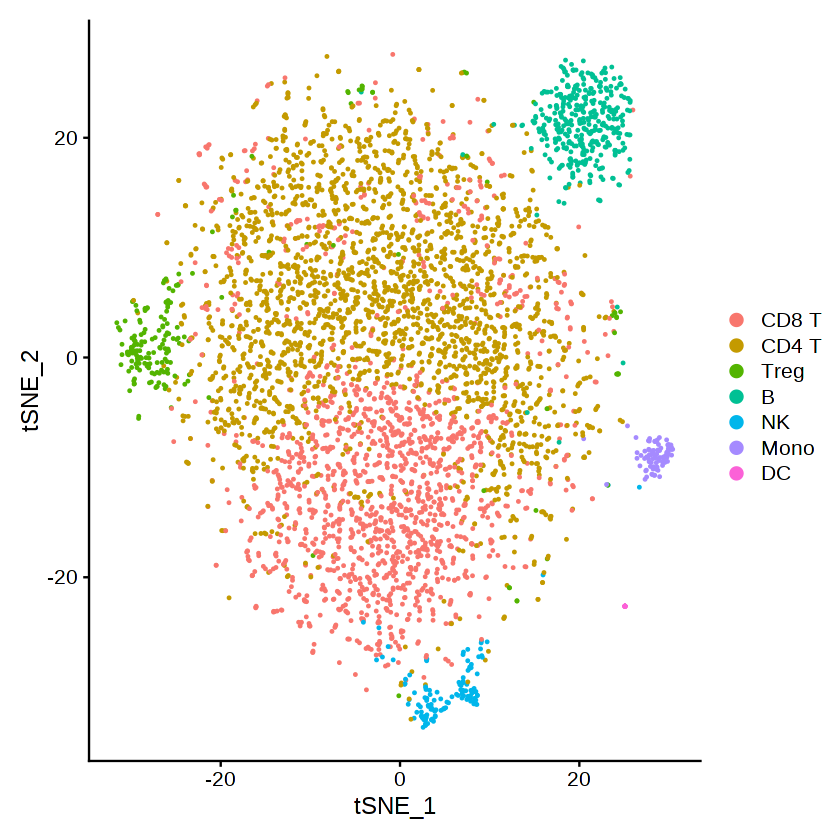

In [3]:
# Visualize which cell populations are present: CD4 T cells (including regulatory T cells), CD8 T cells, B cells, NK cells, dendritic cells (DCs) and inflammatory monocytes
seuratObj@meta.data$celltype %>% table() # note that the number of cells of some cell types is very low and should preferably be higher for a real application
DimPlot(seuratObj, reduction = "tsne")

.
LCMV   SS 
3886 1141 

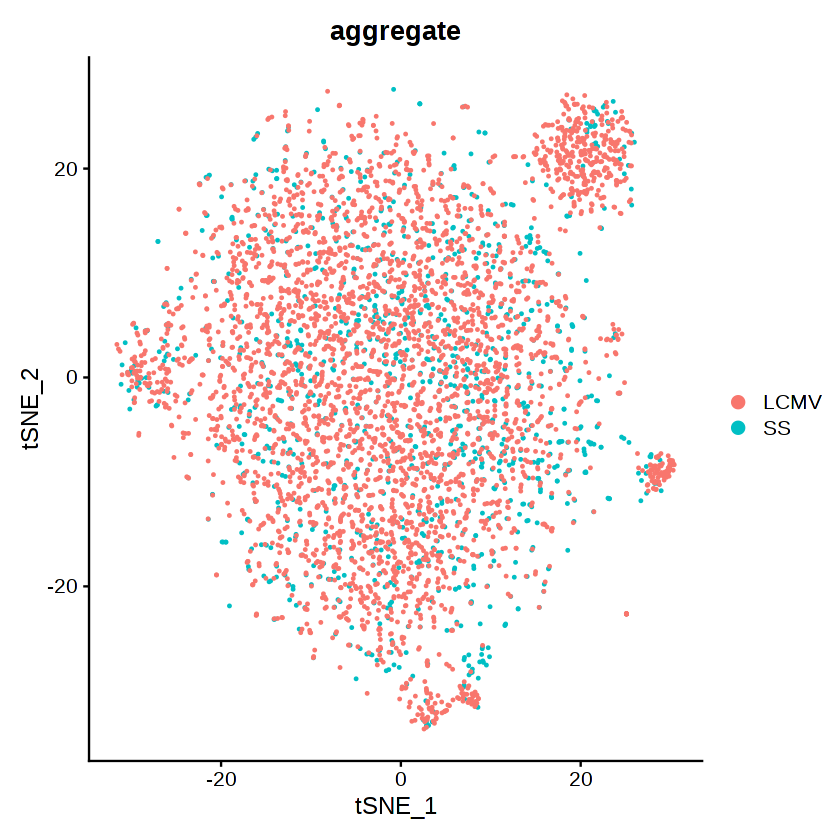

In [4]:
# Visualize the data to see to which condition cells belong
seuratObj@meta.data$aggregate %>% table()
DimPlot(seuratObj, reduction = "tsne", group.by = "aggregate")

In [5]:
# Read in NicheNet’s ligand-target prior model, ligand-receptor network and weighted integrated networks:
ligand_target_matrix <- readRDS("ligand_target_matrix.rds")
ligand_target_matrix[1:5,1:5]

,CXCL1,CXCL2,CXCL3,CXCL5,PPBP
A1BG,3.534343e-04,4.041324e-04,3.729920e-04,3.080640e-04,2.628388e-04
A1BG-AS1,1.650894e-04,1.509213e-04,1.583594e-04,1.317253e-04,1.231819e-04
A1CF,5.787175e-04,4.596295e-04,3.895907e-04,3.293275e-04,3.211944e-04
A2M,6.027058e-04,5.996617e-04,5.164365e-04,4.517236e-04,4.590521e-04
A2M-AS1,8.898724e-05,8.243341e-05,7.484018e-05,4.912514e-05,5.120439e-05


In [6]:
lr_network <- readRDS("lr_network.rds")
head(lr_network)

from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL1,CXCR2,kegg_cytokines,kegg
CXCL2,CXCR2,kegg_cytokines,kegg
CXCL3,CXCR2,kegg_cytokines,kegg
CXCL5,CXCR2,kegg_cytokines,kegg
PPBP,CXCR2,kegg_cytokines,kegg
CXCL6,CXCR2,kegg_cytokines,kegg


In [7]:
weighted_networks <- readRDS("weighted_networks.rds")
weighted_networks_lr <- weighted_networks$lr_sig %>% inner_join(lr_network %>% distinct(from,to), by = c("from","to"))
head(weighted_networks$lr_sig) # interactions and their weights in the ligand-receptor + signaling network

from,to,weight
<chr>,<chr>,<dbl>
A1BG,ABCC6,0.42164389
A1BG,ACE2,0.10074109
A1BG,ADAM10,0.09698978
A1BG,AGO1,0.05245879
A1BG,AKT1,0.08553468
A1BG,ANXA7,0.45659947


In [8]:
head(weighted_networks$gr) # interactions and their weights in the gene regulatory network

from,to,weight
<chr>,<chr>,<dbl>
A1BG,A2M,0.02944793
AAAS,GFAP,0.02904173
AADAC,CYP3A4,0.04215706
AADAC,IRF8,0.02745930
AATF,ATM,0.03299318
AATF,ATR,0.03545127


Because the expression data is of mouse origin, we will convert the NicheNet network gene symbols from human to mouse based on one-to-one orthology:

In [9]:
lr_network <- lr_network %>% mutate(from = convert_human_to_mouse_symbols(from), to = convert_human_to_mouse_symbols(to)) %>% drop_na()
colnames(ligand_target_matrix) <- ligand_target_matrix %>% colnames() %>% convert_human_to_mouse_symbols()
rownames(ligand_target_matrix) <- ligand_target_matrix %>% rownames() %>% convert_human_to_mouse_symbols()
ligand_target_matrix <- ligand_target_matrix %>% .[!is.na(rownames(ligand_target_matrix)), !is.na(colnames(ligand_target_matrix))]
weighted_networks_lr <- weighted_networks_lr %>% mutate(from = convert_human_to_mouse_symbols(from), to = convert_human_to_mouse_symbols(to)) %>% drop_na()

## Perform the NicheNet analysis
In this case study, we want to apply NicheNet to predict which ligands expressed by all immune cells in the T cell area of the lymph node are most likely to have induced the differential expression in CD8 T cells after LCMV infection.

**1. Define a “sender/niche” cell population and a “receiver/target” cell population present in your expression data and determine which genes are expressed in both populations**

In [10]:
# receiver
receiver <- "CD8 T"
expressed_genes_receiver <- get_expressed_genes(receiver, seuratObj, pct = 0.10)
background_expressed_genes <- expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]
# sender
sender_celltypes <- c("CD4 T","Treg", "Mono", "NK", "B", "DC")
list_expressed_genes_sender <- sender_celltypes %>% unique() %>% lapply(get_expressed_genes, seuratObj, 0.10) # lapply to get the expressed genes of every sender cell type separately here
expressed_genes_sender <- list_expressed_genes_sender %>% unlist() %>% unique()

**2. Define a gene set of interest: these are the genes in the “receiver/target” cell population that are potentially affected by ligands expressed by interacting cells (e.g. genes differentially expressed upon cell-cell interaction)**

Here, the gene set of interest are the genes differentially expressed in CD8 T cells after LCMV infection. The condition of interest is thus ‘LCMV,’ whereas the reference/steady-state condition is ‘SS.’ The notion of conditions can be extracted from the metadata column ‘aggregate.’ The method to calculate the differential expression is here the standard Seurat Wilcoxon test, but this can be changed if necessary.

In [11]:
seurat_obj_receiver <- subset(seuratObj, idents = receiver)
seurat_obj_receiver <- SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["aggregate"]])
condition_oi <- "LCMV"
condition_reference <- "SS" 
DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, ident.1 = condition_oi, ident.2 = condition_reference, min.pct = 0.10) %>% rownames_to_column("gene")
geneset_oi <- DE_table_receiver %>% filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25) %>% pull(gene)
geneset_oi <- geneset_oi %>% .[. %in% rownames(ligand_target_matrix)]

**3. Define a set of potential ligands: these are ligands that are expressed by the “sender/niche” cell population and bind a (putative) receptor expressed by the “receiver/target” population**

In [12]:
ligands <- lr_network %>% pull(from) %>% unique()
receptors <- lr_network %>% pull(to) %>% unique()
expressed_ligands <- intersect(ligands,expressed_genes_sender)
expressed_receptors <- intersect(receptors,expressed_genes_receiver)
potential_ligands = lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors) %>% pull(from) %>% unique()

**4. Perform NicheNet ligand activity analysis: rank the potential ligands based on the presence of their target genes in the gene set of interest (compared to the background set of genes)**

test_ligand,auroc,aupr,pearson,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Ebi3,0.6380328,0.2338313,0.1966668360,1
Il15,0.5816783,0.1629499,0.0961306338,2
Crlf2,0.5491520,0.1626806,0.0757842307,3
App,0.4993160,0.1407018,0.0654842262,4
Tgfb1,0.4939636,0.1402407,0.0557858622,5
Ptprc,0.5355342,0.1490291,0.0553601950,6
H2-M3,0.5254557,0.1572048,0.0527500353,7
Icam1,0.5425182,0.1423450,0.0485857841,8
Cxcl10,0.5309152,0.1408411,0.0407525529,9


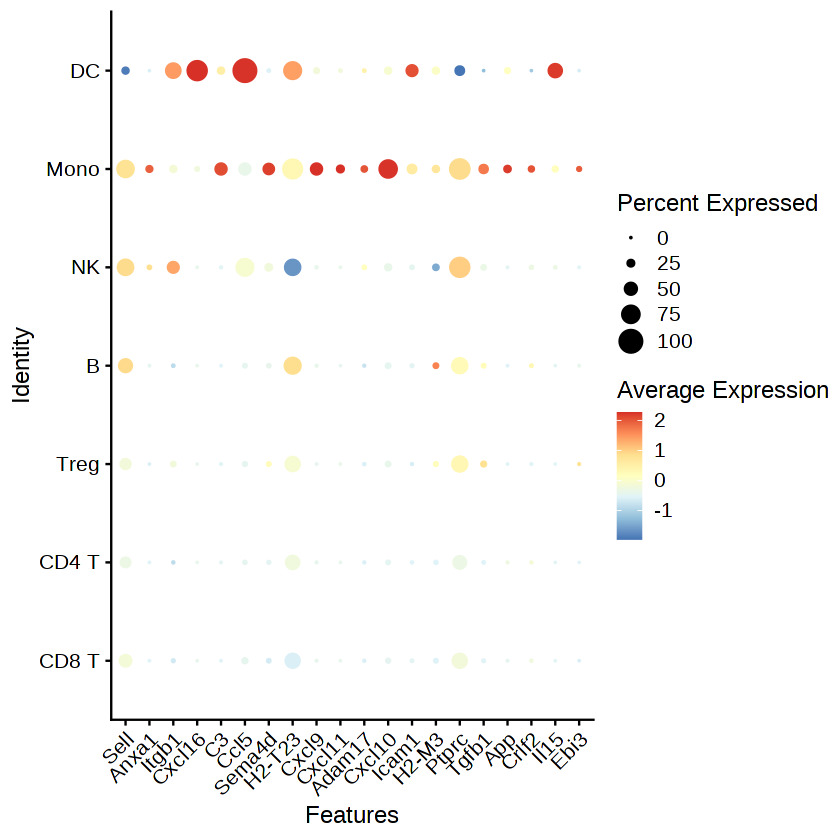

In [13]:
ligand_activities <- predict_ligand_activities(geneset = geneset_oi, background_expressed_genes = background_expressed_genes, ligand_target_matrix = ligand_target_matrix, potential_ligands = potential_ligands)
ligand_activities <- ligand_activities %>% arrange(-pearson) %>% mutate(rank = rank(desc(pearson)))
ligand_activities
best_upstream_ligands <- ligand_activities %>% top_n(20, pearson) %>% arrange(-pearson) %>% pull(test_ligand) %>% unique()  #20 top-ranked ligands that are further used to predict active target genes and construct an active ligand-receptor network
DotPlot(seuratObj, features = best_upstream_ligands %>% rev(), cols = "RdYlBu") + RotatedAxis()

As you can see, most op the top-ranked ligands seem to be mainly expressed by dendritic cells and monocytes.

**5. Infer receptors and top-predicted target genes of ligands that are top-ranked in the ligand activity analysis**

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



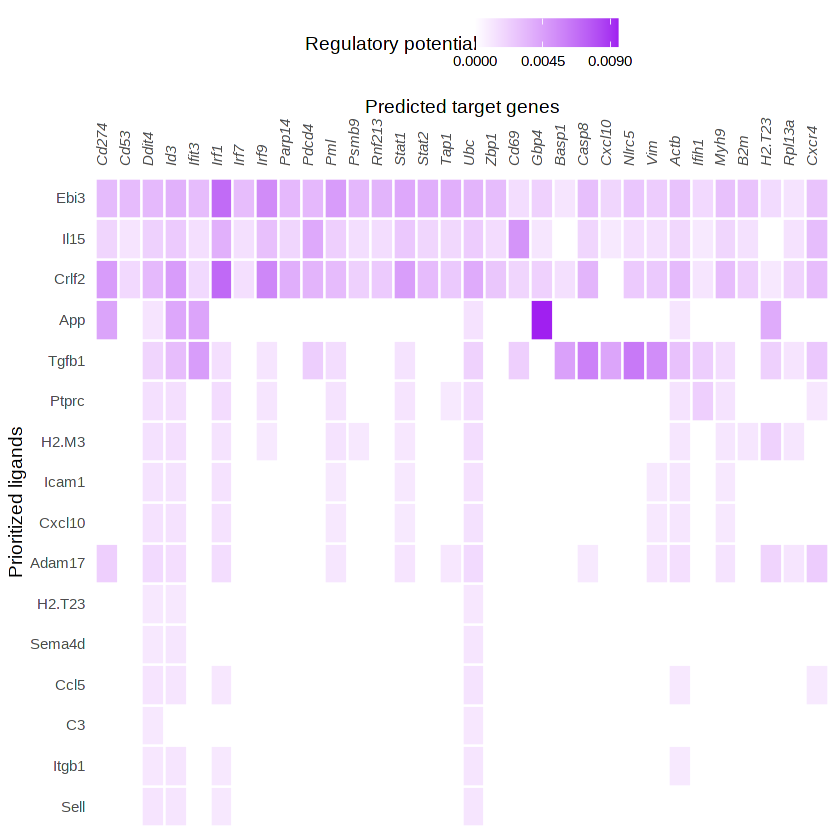

In [14]:
# Active target gene inference
active_ligand_target_links_df <- best_upstream_ligands %>% lapply(get_weighted_ligand_target_links,geneset = geneset_oi, ligand_target_matrix = ligand_target_matrix, n = 200) %>% bind_rows() %>% drop_na()
active_ligand_target_links <- prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, ligand_target_matrix = ligand_target_matrix, cutoff = 0.33)
order_ligands <- intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev() %>% make.names()
order_targets <- active_ligand_target_links_df$target %>% unique() %>% intersect(rownames(active_ligand_target_links)) %>% make.names()
rownames(active_ligand_target_links) <- rownames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23
colnames(active_ligand_target_links) <- colnames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23
vis_ligand_target <- active_ligand_target_links[order_targets,order_ligands] %>% t()
p_ligand_target_network <- vis_ligand_target %>% make_heatmap_ggplot("Prioritized ligands","Predicted target genes", color = "purple",legend_position = "top", x_axis_position = "top",legend_title = "Regulatory potential")  + theme(axis.text.x = element_text(face = "italic")) + scale_fill_gradient2(low = "whitesmoke",  high = "purple", breaks = c(0,0.0045,0.0090))
p_ligand_target_network

Note that not all ligands from the top 20 are present in this ligand-target heatmap. The left-out ligands are ligands that don’t have target genes with high enough regulatory potential scores. Therefore, they did not survive the used cutoffs. To include them, you can be less stringent in the used cutoffs.

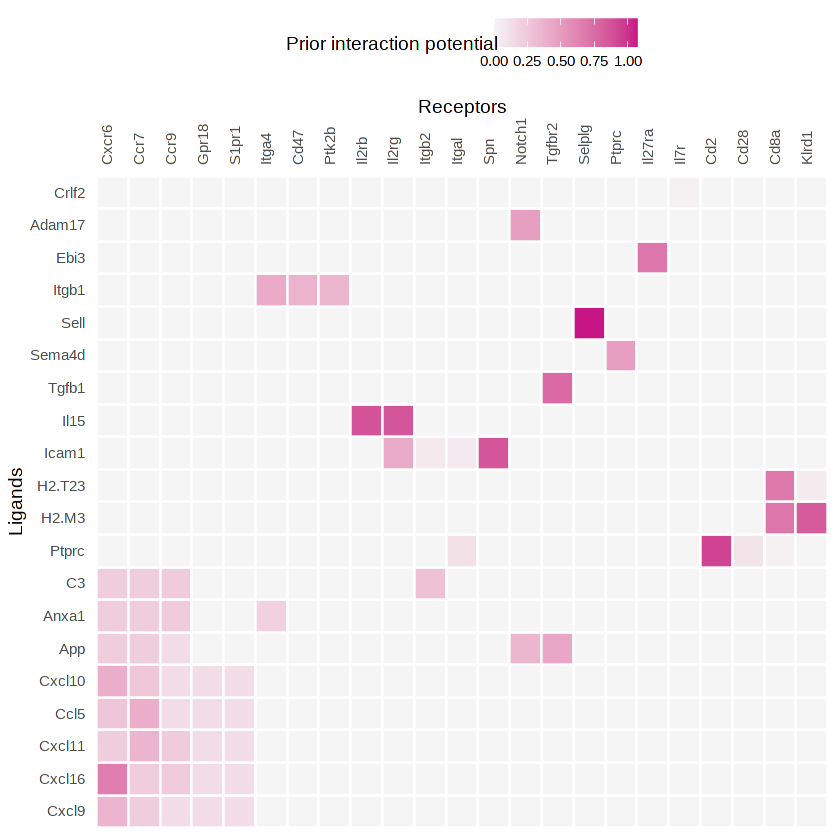

In [15]:
# Receptors of top-ranked ligands
lr_network_top <- lr_network %>% filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% distinct(from,to)
best_upstream_receptors <- lr_network_top %>% pull(to) %>% unique()
lr_network_top_df_large <- weighted_networks_lr %>% filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors)
lr_network_top_df <- lr_network_top_df_large %>% spread("from","weight",fill = 0)
lr_network_top_matrix <- lr_network_top_df %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to)
dist_receptors <- dist(lr_network_top_matrix, method = "binary")
hclust_receptors <- hclust(dist_receptors, method = "ward.D2")
order_receptors <- hclust_receptors$labels[hclust_receptors$order]
dist_ligands <- dist(lr_network_top_matrix %>% t(), method = "binary")
hclust_ligands <- hclust(dist_ligands, method = "ward.D2")
order_ligands_receptor <- hclust_ligands$labels[hclust_ligands$order]
order_receptors <- order_receptors %>% intersect(rownames(lr_network_top_matrix))
order_ligands_receptor <- order_ligands_receptor %>% intersect(colnames(lr_network_top_matrix))
vis_ligand_receptor_network <- lr_network_top_matrix[order_receptors, order_ligands_receptor]
rownames(vis_ligand_receptor_network) <- order_receptors %>% make.names()
colnames(vis_ligand_receptor_network) <- order_ligands_receptor %>% make.names()
p_ligand_receptor_network <- vis_ligand_receptor_network %>% t() %>% make_heatmap_ggplot("Ligands","Receptors", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential")
p_ligand_receptor_network

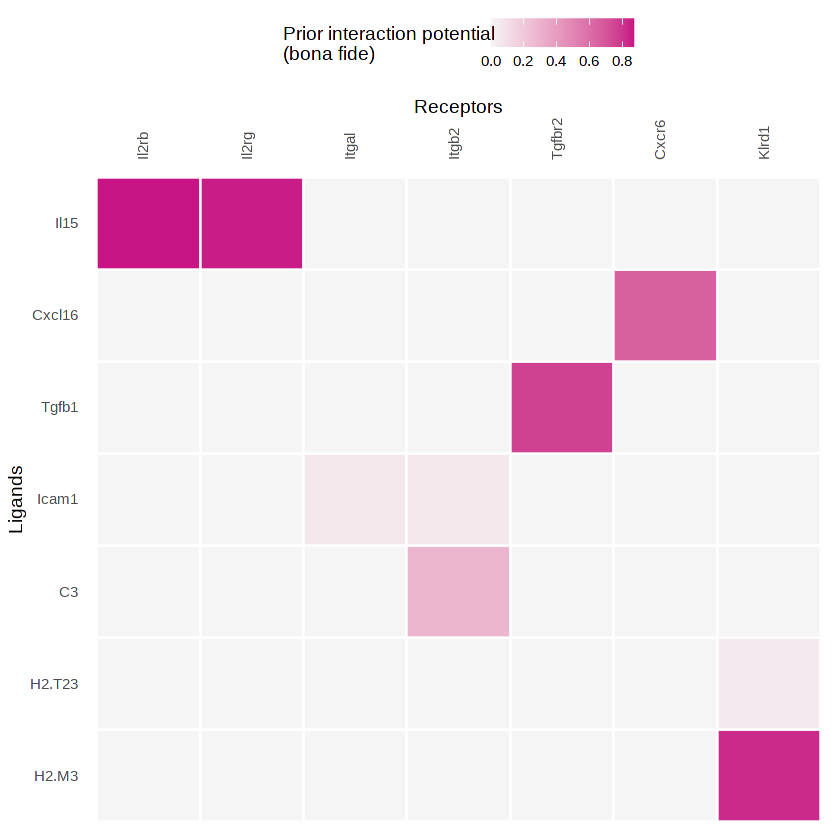

In [16]:
# Receptors of top-ranked ligands, but after considering only bona fide ligand-receptor interactions documented in literature and publicly available databases
lr_network_strict <- lr_network %>% filter(database != "ppi_prediction_go" & database != "ppi_prediction")
ligands_bona_fide <- lr_network_strict %>% pull(from) %>% unique()
receptors_bona_fide <- lr_network_strict %>% pull(to) %>% unique()
lr_network_top_df_large_strict <- lr_network_top_df_large %>% distinct(from,to) %>% inner_join(lr_network_strict, by = c("from","to")) %>% distinct(from,to)
lr_network_top_df_large_strict <- lr_network_top_df_large_strict %>% inner_join(lr_network_top_df_large, by = c("from","to"))
lr_network_top_df_strict <- lr_network_top_df_large_strict %>% spread("from","weight",fill = 0)
lr_network_top_matrix_strict <- lr_network_top_df_strict %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df_strict$to)
dist_receptors <- dist(lr_network_top_matrix_strict, method = "binary")
hclust_receptors <- hclust(dist_receptors, method = "ward.D2")
order_receptors <- hclust_receptors$labels[hclust_receptors$order]
dist_ligands <- dist(lr_network_top_matrix_strict %>% t(), method = "binary")
hclust_ligands <- hclust(dist_ligands, method = "ward.D2")
order_ligands_receptor <- hclust_ligands$labels[hclust_ligands$order]
order_receptors <- order_receptors %>% intersect(rownames(lr_network_top_matrix_strict))
order_ligands_receptor <- order_ligands_receptor %>% intersect(colnames(lr_network_top_matrix_strict))
vis_ligand_receptor_network_strict <- lr_network_top_matrix_strict[order_receptors, order_ligands_receptor]
rownames(vis_ligand_receptor_network_strict) <- order_receptors %>% make.names()
colnames(vis_ligand_receptor_network_strict) <- order_ligands_receptor %>% make.names()
p_ligand_receptor_network_strict <- vis_ligand_receptor_network_strict %>% t() %>% make_heatmap_ggplot("Ligands","Receptors", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential\n(bona fide)")
p_ligand_receptor_network_strict

**6. Add log fold change information of ligands from sender cells**

In some cases, it might be possible to also check upregulation of ligands in sender cells. This can add a useful extra layer of information next to the ligand activities defined by NicheNet, because you can assume that some of the ligands inducing DE in receiver cells, will be DE themselves in the sender cells.

Here this is possible: we will define the log fold change between LCMV and steady-state in all sender cell types and visualize this as extra information.

Joining, by = "gene"

Joining, by = "gene"

Joining, by = "gene"

Joining, by = "gene"

Joining, by = "gene"

Joining, by = "ligand"



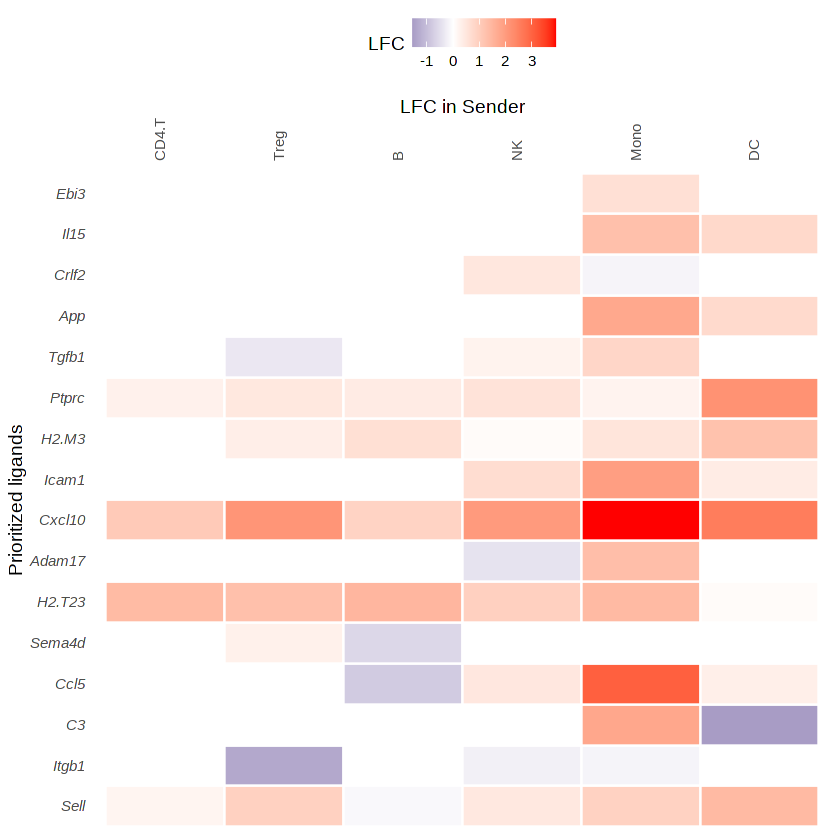

In [17]:
# DE analysis for each sender cell type
DE_table_all <- Idents(seuratObj) %>% levels() %>% intersect(sender_celltypes) %>% lapply(get_lfc_celltype, seurat_obj = seuratObj, condition_colname = "aggregate", condition_oi = condition_oi, condition_reference = condition_reference, expression_pct = 0.10) %>% reduce(full_join)
DE_table_all[is.na(DE_table_all)] <- 0

# Combine ligand activities with DE information
ligand_activities_de <- ligand_activities %>% select(test_ligand, pearson) %>% rename(ligand = test_ligand) %>% left_join(DE_table_all %>% rename(ligand = gene))
ligand_activities_de[is.na(ligand_activities_de)] <- 0

# make LFC heatmap
lfc_matrix <- ligand_activities_de  %>% select(-ligand, -pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities_de$ligand)
rownames(lfc_matrix) <- rownames(lfc_matrix) %>% make.names()

order_ligands <- order_ligands[order_ligands %in% rownames(lfc_matrix)]
vis_ligand_lfc <- lfc_matrix[order_ligands,]

colnames(vis_ligand_lfc) <- vis_ligand_lfc %>% colnames() %>% make.names()

p_ligand_lfc <- vis_ligand_lfc %>% make_threecolor_heatmap_ggplot("Prioritized ligands","LFC in Sender", low_color = "midnightblue",mid_color = "white", mid = median(vis_ligand_lfc), high_color = "red",legend_position = "top", x_axis_position = "top", legend_title = "LFC") + theme(axis.text.y = element_text(face = "italic"))
p_ligand_lfc

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



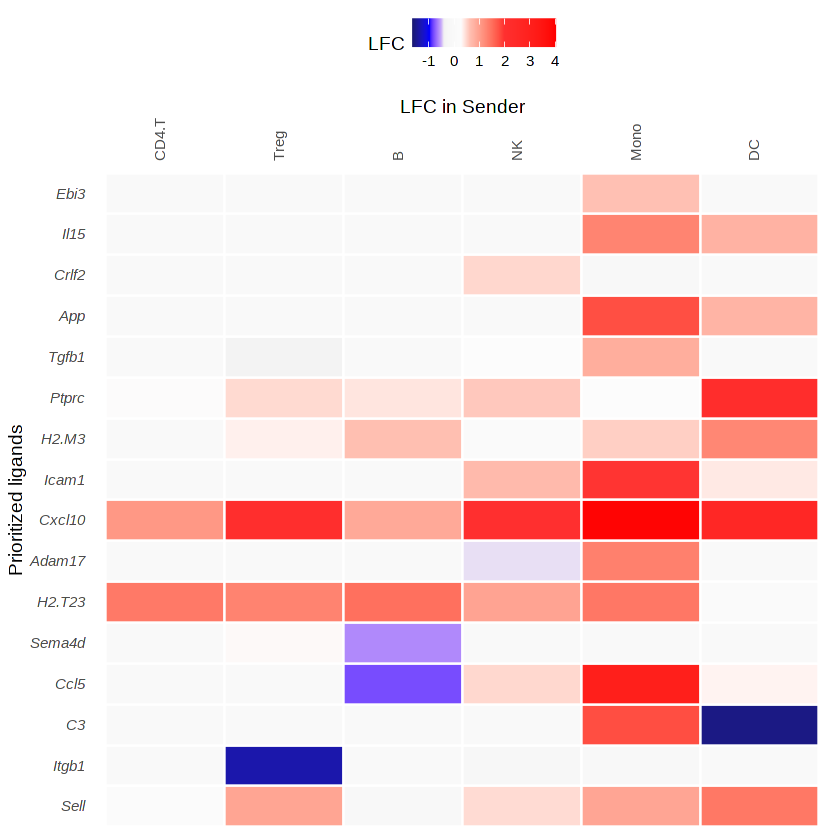

In [18]:
# change colors a bit to make them more stand out
p_ligand_lfc <- p_ligand_lfc + scale_fill_gradientn(colors = c("midnightblue","blue", "grey95", "grey99","firebrick1","red"),values = c(0,0.1,0.2,0.25, 0.40, 0.7,1), limits = c(vis_ligand_lfc %>% min() - 0.1, vis_ligand_lfc %>% max() + 0.1))
p_ligand_lfc

**7. Summary visualizations of the NicheNet analysis**

In [19]:
# ligand activity heatmap
ligand_pearson_matrix <- ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand)

rownames(ligand_pearson_matrix) <- rownames(ligand_pearson_matrix) %>% make.names()
colnames(ligand_pearson_matrix) <- colnames(ligand_pearson_matrix) %>% make.names()

vis_ligand_pearson <- ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson")
p_ligand_pearson <- vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)") + theme(legend.text = element_text(size = 9))

In [20]:
# ligand expression Seurat dotplot
order_ligands_adapted <- order_ligands
order_ligands_adapted[order_ligands_adapted == "H2.M3"] <- "H2-M3" # cf required use of make.names for heatmap visualization | this is not necessary if these ligands are not in the list of prioritized ligands!
order_ligands_adapted[order_ligands_adapted == "H2.T23"] <- "H2-T23" # cf required use of make.names for heatmap visualization | this is not necessary if these ligands are not in the list of prioritized ligands!
rotated_dotplot <- DotPlot(seuratObj %>% subset(celltype %in% sender_celltypes), features = order_ligands_adapted, cols = "RdYlBu") + coord_flip() + theme(legend.text = element_text(size = 10), legend.title = element_text(size = 12)) # flip of coordinates necessary because we want to show ligands in the rows when combining all plots

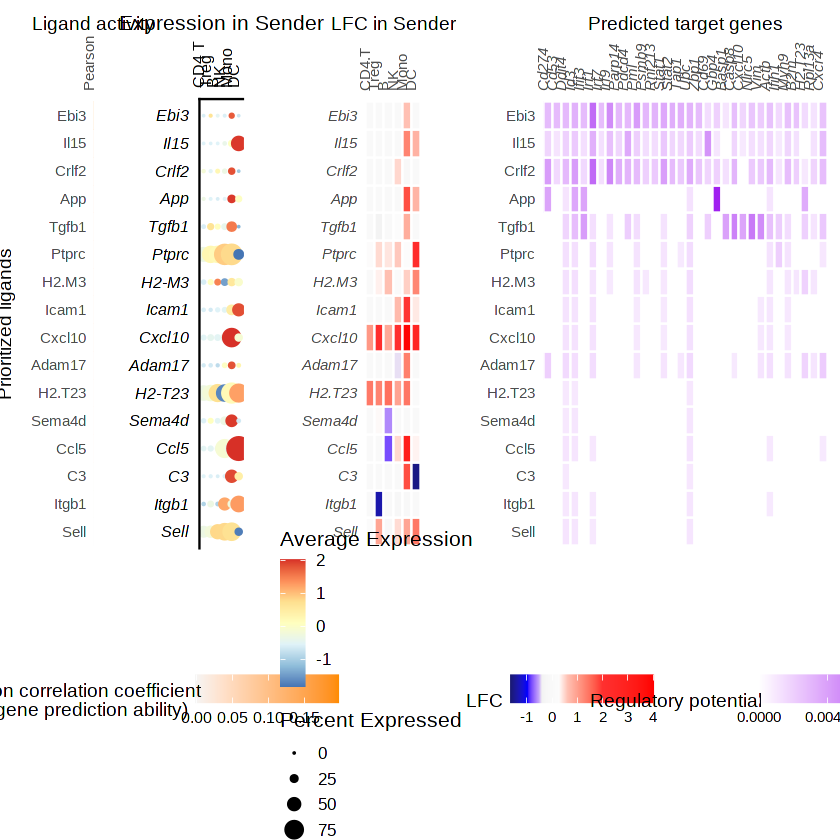

In [21]:
figures_without_legend <- cowplot::plot_grid(
  p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()),
  rotated_dotplot + theme(legend.position = "none", axis.ticks = element_blank(), axis.title.x = element_text(size = 12), axis.text.y = element_text(face = "italic", size = 9), axis.text.x = element_text(size = 9,  angle = 90,hjust = 0)) + ylab("Expression in Sender") + xlab("") + scale_y_discrete(position = "right"),
  p_ligand_lfc + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()) + ylab(""),
  p_ligand_target_network + theme(legend.position = "none", axis.ticks = element_blank()) + ylab(""),
  align = "hv",
  nrow = 1,
  rel_widths = c(ncol(vis_ligand_pearson)+6, ncol(vis_ligand_lfc) + 7, ncol(vis_ligand_lfc) + 8, ncol(vis_ligand_target)))

legends <- cowplot::plot_grid(
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_pearson)),
    ggpubr::as_ggplot(ggpubr::get_legend(rotated_dotplot)),
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_lfc)),
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_target_network)),
    nrow = 1,
    align = "h", rel_widths = c(1.5, 1, 1, 1))

combined_plot <- cowplot::plot_grid(figures_without_legend, legends, rel_heights = c(10,5), nrow = 2, align = "hv")
combined_plot

Last updated: June 12,2021